# Box-Jenkins method for time series forecasting

### First let us explore the data that we are dealing with https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview

In [1]:
import pandas as pd

In [12]:
data = pd.read_csv('train.csv')
data['date'] = pd.to_datetime(data['date'])
#data = data.set_index('date').asfreq('D')

In [4]:
print(len(data['store'].unique()))
print(len(data['item'].unique()))

10
50


In [10]:
print(data.shape)
pd.DataFrame(data.value_counts(subset=['store', 'item'], ascending=False))

(913000, 4)


0
store item      
1     1     1826
7     30    1826
      43    1826
      42    1826
      41    1826
...          ...
4     12    1826
      11    1826
      10    1826
      9     1826
10    50    1826

[500 rows x 1 columns]

#### There are 50 items in each store and there are 10 of them with 913000 rows. Data seems to be balanced since each item on a certain store has 1826
#### Since analysing time series data only works with continious single labels, we need to take one store and item dataset
#### Use a groupby to get a suitable data

In [13]:
grouped_data =data.groupby(['store', 'item'], as_index=False).sum()
highest_sales = grouped_data['sales'].idxmax()
sample = grouped_data.loc[highest_sales,:]

In [14]:
sample_forecast = data[data['store']==sample['store']][data['item']==sample['item']]
sample_forecast = pd.DataFrame(sample_forecast.set_index('date').asfreq('D')['sales'])

/tmp/ipykernel_5283/663655323.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_forecast = data[data['store']==sample['store']][data['item']==sample['item']]


In [15]:
sample_forecast

,sales
date,
2013-01-01,45
2013-01-02,53
2013-01-03,65
2013-01-04,66
2013-01-05,97
...,...
2017-12-27,82
2017-12-28,114
2017-12-29,101


### Let's make a baseline model
#### with just OLS from statsmodel
#### scoring with AIC lower the better and more robust than r2 score, do not care for absolute values
Reference is Model Selection and Multi-model Inference: A Practical Information-theoretic Approach (Burnham and Anderson, 2004), particularly on page 62 (section 2.2):

In application, one computes AIC for each of the candidate models and selects the model with the smallest value of AIC.

as well as on page 63:

Usually, AIC is positive; however, it can be shifted by any additive constant, and some shifts can result in negative values of AIC. [...] It is not the absolute size of the AIC value, it is the relative values over the set of models considered, and particularly the differences between AIC values, that are important.

In [18]:
# Let's keep the last 20% of the values out for testing purposes
train_size = 0.8
index = round(train_size*sample_forecast.shape[0])

df_train = sample_forecast.iloc[:index]
df_test = sample_forecast.iloc[index:]

In [103]:
x = sm.add_constant(df_train)

In [113]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
#fit regression model
series_index = pd.RangeIndex(start=0, stop=1461, step=1).to_list()
model = sm.OLS(df_train['sales'], x[['const']]).fit()

#view AIC of model
print(model.aic)

13905.953806496176


Value is quite high for this AIC

In [114]:
x_test = sm.add_constant(df_test)

In [115]:
model.predict(x_test[['const']])

date
2017-01-01    109.201916
2017-01-02    109.201916
2017-01-03    109.201916
2017-01-04    109.201916
2017-01-05    109.201916
                 ...    
2017-12-27    109.201916
2017-12-28    109.201916
2017-12-29    109.201916
2017-12-30    109.201916
2017-12-31    109.201916
Freq: D, Length: 365, dtype: float64

In [154]:
y_pred = pd.DataFrame(model.predict(x_test[['const']]))
y_pred.index = df_test.index

In [160]:
conf_int_ols = model.conf_int(alpha=0.05, cols=None)
conf_int_ols = conf_int_ols.rename(columns={0:'low', 1:'high'})
y_pred['low'] = conf_int_ols['low'].values[0]
y_pred['high'] = conf_int_ols['high'].values[0]

In [164]:
y_pred.rename(columns={0:'sales'}, inplace=True)

In [165]:
import matplotlib.pyplot as plt

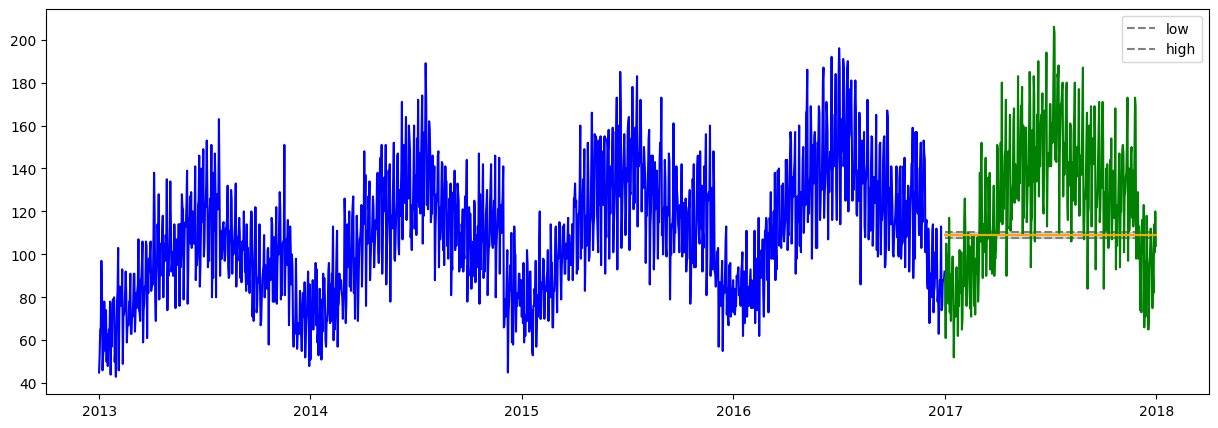

In [166]:
plt.figure(figsize=(15,5))


plt.plot((y_pred['low']), label='low', c='grey', ls='--')
plt.plot((y_pred['high']), label='high', c='grey', ls='--')
plt.plot(df_train, c='blue')
plt.plot(df_test, c='green')
plt.plot(y_pred['sales'], c='orange')
plt.legend();

plt.fill_between(df_test.index, y_pred['low'], y_pred['high'], color='k', alpha=.15);

### Most time series models work by stationary
### as seen from the graph the time series has seasonality and slight trend!!
### hence we need to decompose it first

In [168]:
from statsmodels.tsa.seasonal import seasonal_decompose

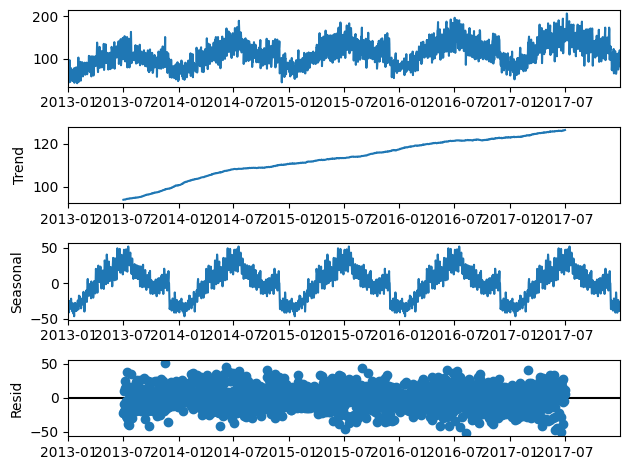

In [169]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(sample_forecast, model='additive', period=365)
result_add.plot();

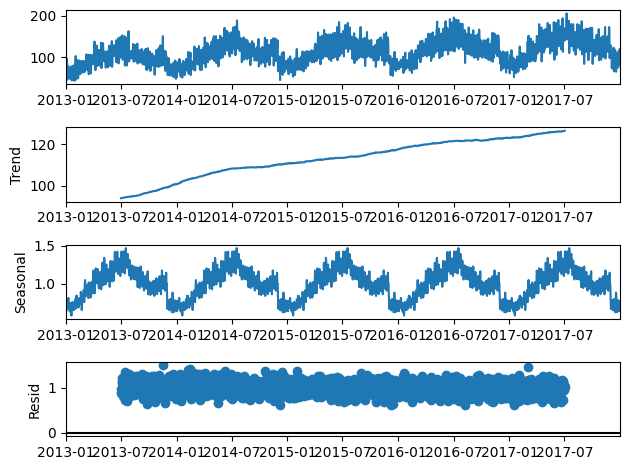

In [170]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(sample_forecast, model='multiplicative', period=365)
result_mul.plot();

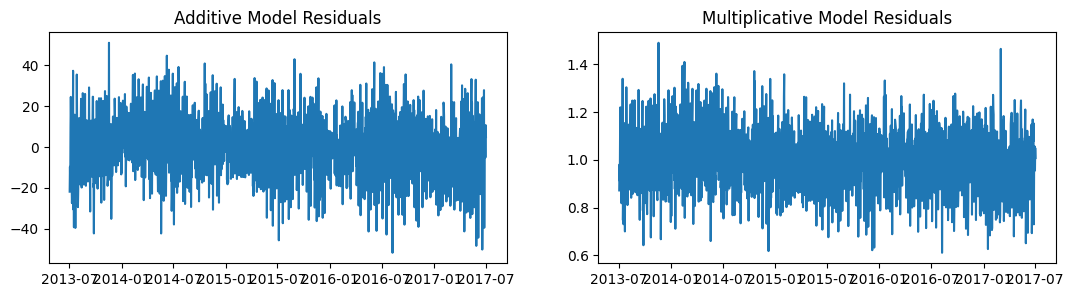

In [171]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals");

### Multiplicative models seems to have less notion of time so it is slightly better
### However some item in a store has zero or Nan seasonaility/trend which makes decomposing them to be an issue
### This where additive models are generally more robust

In [173]:
from statsmodels.tsa.stattools import adfuller

### Another indicator is the adfuller test, the results below after decomposistion shows that our dataset has become stationary
#### assuming alpha of 0.05

In [174]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  9.525618492272553e-09
multiplicative resid:  5.134865666325213e-12


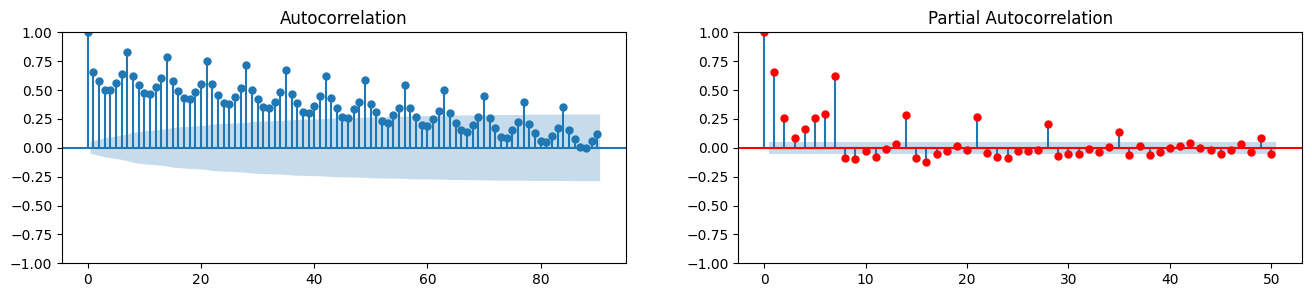

In [175]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(df_train.sales, lags=90, ax=axes[0]);
plot_pacf(df_train.sales, lags=50, ax=axes[1], color='r', method='ywm');

In [176]:
result_mul

### ACF interpertation
#### Because of the trend and seasonaility,  the autocorrelations are larger for lags at multiples of the seasonal frequency than for other lags. Notice the wavy points and diminishing autocorrelation over larger lags. Simplier models overall are better starting with third order auto-regressive model but up to the fifth model for our auto grid search in arima

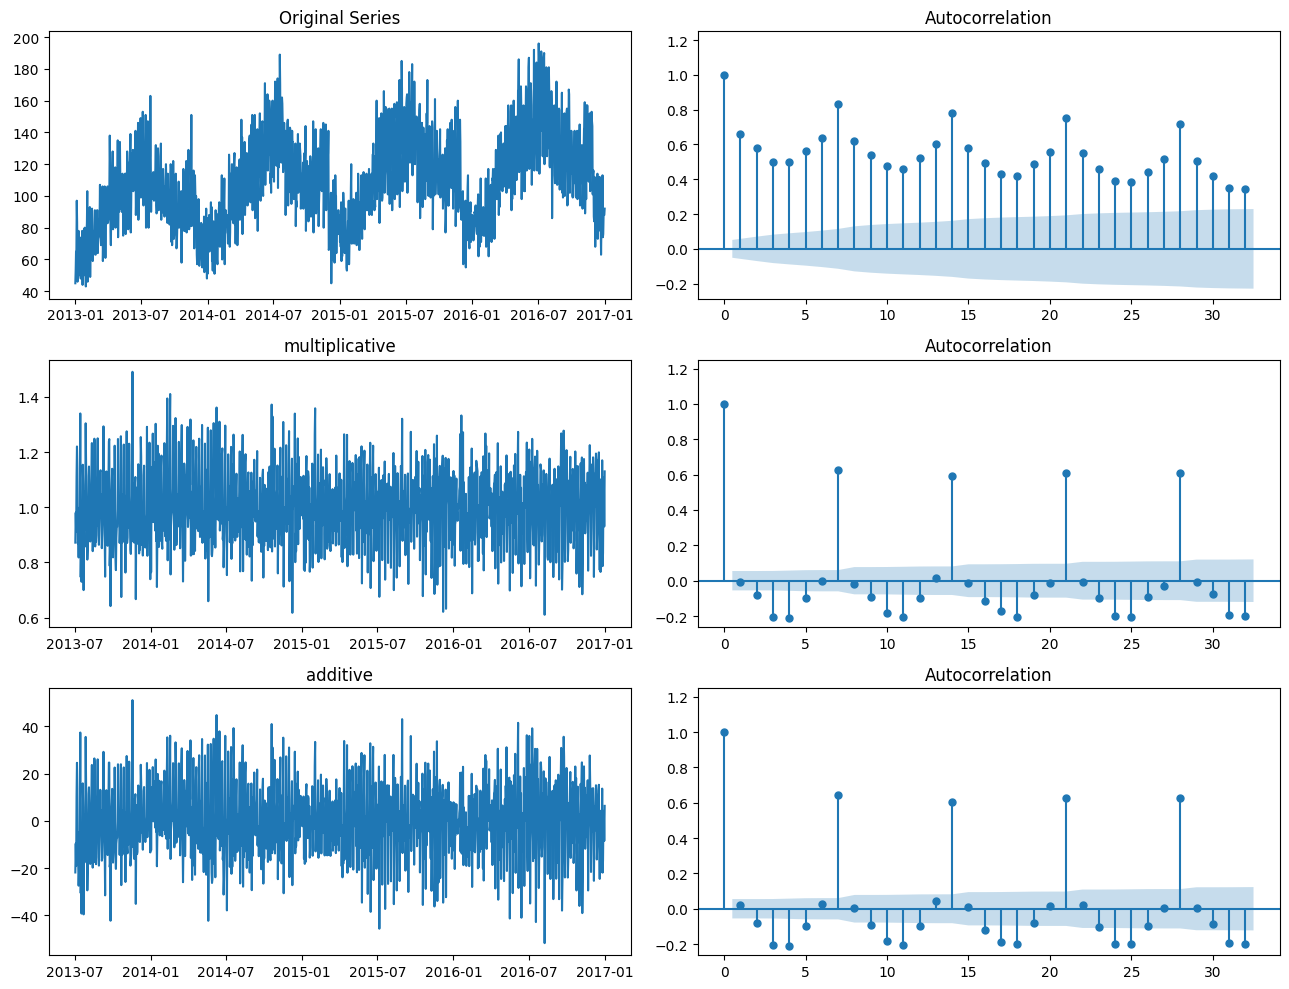

In [178]:
import numpy as np
# 0th Differencing
fig, axes = plt.subplots(3, 2, figsize=(13,10))
axes[0, 0].plot(df_train); axes[0, 0].set_title('Original Series')
plot_acf(df_train, auto_ylims=True,ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_train['sales']/result_mul.seasonal/result_mul.trend); axes[1, 0].set_title('multiplicative')
plot_acf((df_train['sales']/result_mul.seasonal/result_mul.trend).dropna(), auto_ylims=True,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_train['sales']-result_add.seasonal-result_add.trend); axes[2, 0].set_title('additive')
plot_acf((df_train['sales']-result_add.seasonal-result_add.trend).dropna(), auto_ylims=True, ax=axes[2, 1])

plt.tight_layout()

In [181]:
adfuller((df_train['sales']/result_mul.seasonal/result_mul.trend).dropna())[1]

1.3649595946257252e-10

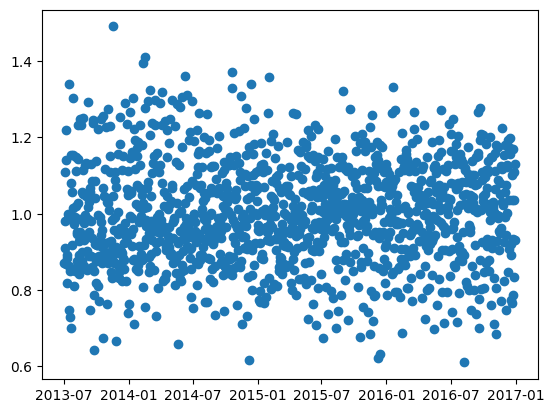

In [182]:
plt.scatter(x=(df_train['sales']/result_mul.seasonal[:index]/result_mul.trend[:index]).dropna().index, y=(df_train['sales']/result_mul.seasonal[:index]/result_mul.trend[:index]).dropna())

Random residuals around the mean generally means the model is stationary

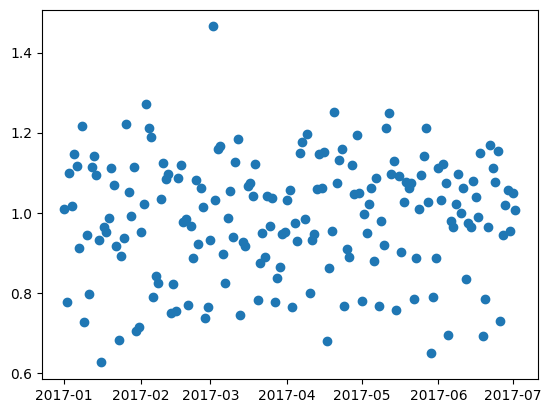

In [183]:
plt.scatter(x=(df_test['sales']/result_mul.seasonal[index:]/result_mul.trend[index:]).dropna().index, y=(df_test['sales']/result_mul.seasonal[index:]/result_mul.trend[index:]).dropna())

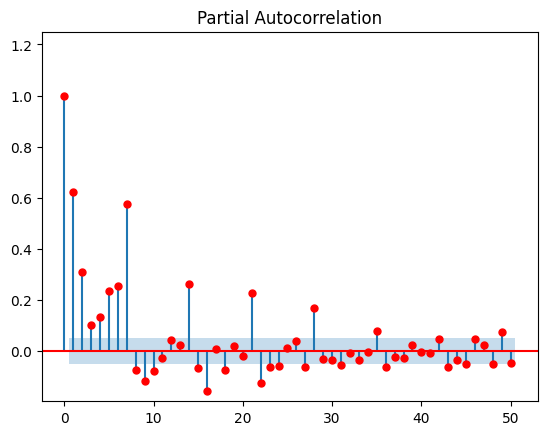

In [184]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf((df_train['sales']/result_mul.seasonal/result_mul.seasonal).dropna(), method='ywm', auto_ylims=True, c='r', use_vlines=True, lags=50, zero=True);

In [185]:
y_diff = (df_train['sales']/result_mul.seasonal/result_mul.trend).dropna()
y_diff_test = (df_test['sales']/result_mul.seasonal/result_mul.trend).dropna()

In [186]:
from statsmodels.tsa.arima.model import ARIMA

# 1. initialize the model
arima = ARIMA(y_diff, order=(2, 0, 0), trend='c')

# 2. fit the models
arima = arima.fit()

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1279
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 745.490
Date:                Wed, 17 May 2023   AIC                          -1482.979
Time:                        20:08:09   BIC                          -1462.364
Sample:                    07-02-2013   HQIC                         -1475.238
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0005      0.004    265.351      0.000       0.993       1.008
ar.L1         -0.0070      0.029     -0.239      0.811      -0.064       0.050
ar.L2         -0.0796      0.032     -2.524      0.012      -0.141      -0.018
sigma2         0.0182      0.001     24.759      0.000       0.017       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 3.10
Prob(Q):                              0.56   Prob(JB):                         0.21
Heteroskedasticity (H):               0.83   Skew:                             0.12
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [189]:
model.aic

13905.953806496176

### Our simple ARIMA already beats our baseline model!!

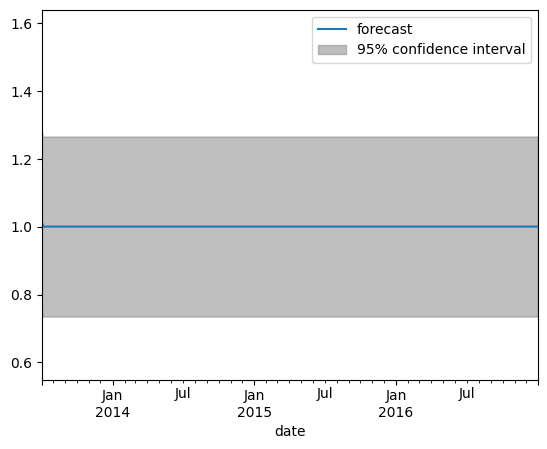

In [32]:
from statsmodels.graphics.tsaplots import plot_predict
# Actual vs Fitted
plot_predict(arima, start=1, dynamic=True);
plt.ylim((.9 * y_diff.min(), 1.1 * y_diff.max()));

In [33]:
forecast_results = arima.get_forecast(365, alpha=0.05)

In [34]:
seasonal_test = pd.DataFrame(result_mul.seasonal[index:].reset_index().seasonal)
seasonal_test.index = df_test.index
trend_test = result_mul.trend[index:].reset_index().trend

In [77]:
result_mul.trend.dropna().shape[0]

1462

In [35]:
trend_test.dropna()

0      122.898630
1      122.772603
2      122.890411
3      122.928767
4      122.958904
          ...    
178    126.164384
179    126.235616
180    126.271233
181    126.358904
182    126.391781
Name: trend, Length: 183, dtype: float64

In [36]:
from sklearn.linear_model import LinearRegression
X = np.array([x for x in range(183)]).reshape(-1,1)
y = trend_test.dropna()
reg = LinearRegression().fit(X, y)

In [37]:
linear_extension = pd.DataFrame(reg.predict(np.array([x for x in range(183, 365)]).reshape(-1,1)))

In [38]:
trend_test = pd.concat([trend_test.dropna(), linear_extension]).reset_index(drop=True)
trend_test.index = df_test.index

In [84]:
sample_forecast.index[0]

2013-01-01 00:00:00


In [40]:
trend_test = trend_test.rename(columns={0:"trend"})

In [85]:
result_mul.trend.dropna()

date
2013-07-02     93.953425
2013-07-03     93.969863
2013-07-04     94.032877
2013-07-05     94.057534
2013-07-06     94.090411
                 ...    
2017-06-28    126.164384
2017-06-29    126.235616
2017-06-30    126.271233
2017-07-01    126.358904
2017-07-02    126.391781
Freq: D, Name: trend, Length: 1462, dtype: float64

### Trend & seasonaility are extended so that they can recompose future dates

In [42]:
forecast = np.array(forecast_results.predicted_mean)*seasonal_test.seasonal*trend_test.trend
forecast = pd.DataFrame(forecast, index=df_test.index)
#forecast = arima.forecast(15, alpha=0.05)
conf_int = pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])
conf_int.index = df_test.index

In [43]:
forecast

,0
date,
2017-01-01,88.659938
2017-01-02,77.864132
2017-01-03,95.590689
2017-01-04,84.769729
2017-01-05,83.813812
...,...
2017-12-27,96.448397
2017-12-28,89.894479
2017-12-29,84.039323


### Multiplicative recomposistion basically just multiply our forecasted residuals multiplied by the extended trend and seasonality
#### Trend extended by OLS linear regression, assumption that the trend will go upwards by the model
#### Seasonality are extended by copying the values from the previous year

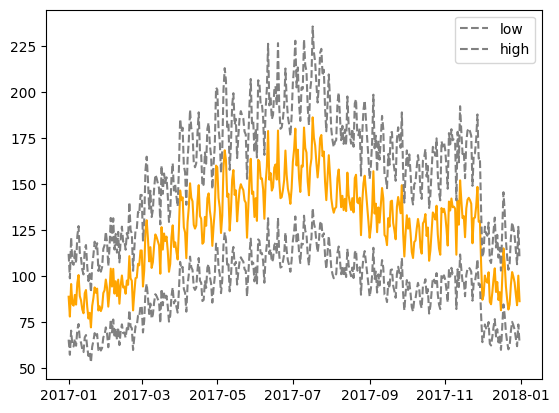

In [44]:
plt.plot(forecast, c='orange')
plt.plot((conf_int['low']*seasonal_test.seasonal*trend_test.trend), label='low', c='grey', ls='--')
plt.plot((conf_int['high']*seasonal_test.seasonal*trend_test.trend), label='high', c='grey', ls='--')
plt.legend();

In [45]:
forecast.index = df_test.index
conf_int.index = df_test.index

In [46]:
conf_int

,low,high
date,,
2017-01-01,0.740448,1.269978
2017-01-02,0.725424,1.254968
2017-01-03,0.734616,1.265832
2017-01-04,0.735741,1.266957
2017-01-05,0.734930,1.266156
...,...,...
2017-12-27,0.734912,1.266138
2017-12-28,0.734912,1.266138
2017-12-29,0.734912,1.266138


### Our forecast is now finished!! 
#### Do note from the partial auto correlation and auto-correlation the peaks suggest we can improve our model somewhat
#### It is likely we need to account some exog variables like holiday/big event dates, SARIMAX, LSTM deep learning, or facebook prophet will be useful
#### Please do contribute to this begginner project!!!

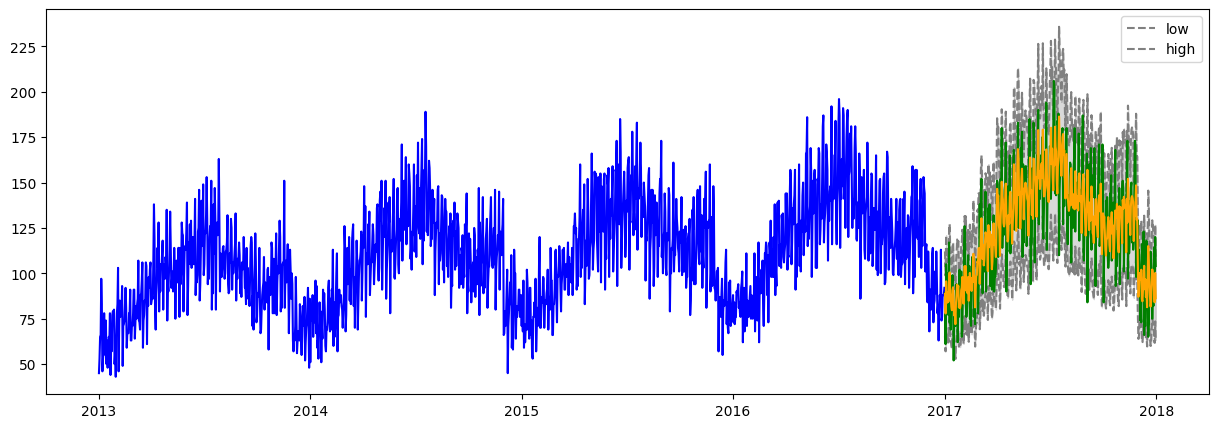

In [47]:
plt.figure(figsize=(15,5))


plt.plot((conf_int['low']*seasonal_test.seasonal*trend_test.trend), label='low', c='grey', ls='--')
plt.plot((conf_int['high']*seasonal_test.seasonal*trend_test.trend), label='high', c='grey', ls='--')
plt.plot(df_train, c='blue')
plt.plot(df_test, c='green')
plt.plot(forecast, c='orange')
plt.legend()
plt.fill_between(df_test.index, (conf_int['low']*seasonal_test.seasonal*trend_test.trend), (conf_int['high']*seasonal_test.seasonal*trend_test.trend), color='k', alpha=.15);

In [48]:
from sklearn.metrics import r2_score
df_test['forecast'] = forecast
r2_score(df_test['sales'], df_test['forecast'])

/tmp/ipykernel_1210/3233371424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['forecast'] = forecast


0.4844895236956891

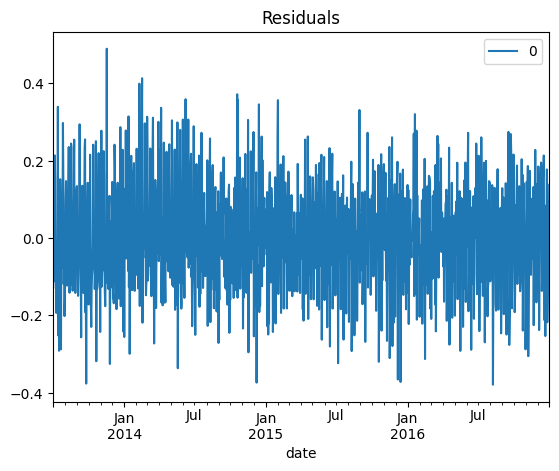

In [49]:
residuals = pd.DataFrame(arima.resid)
residuals.plot(title="Residuals");

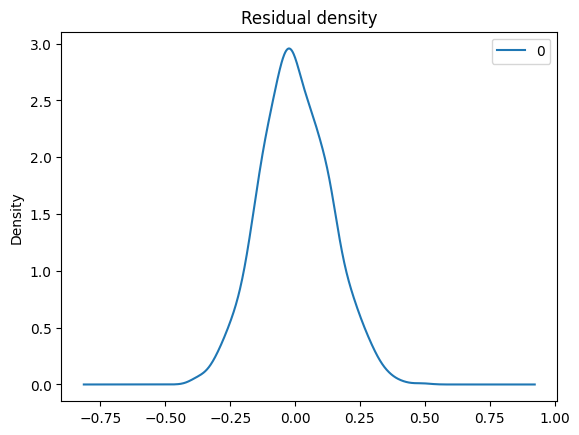

In [50]:
residuals.plot(kind='kde', title='Residual density');

In [55]:
import pmdarima as pm
smodel = pm.auto_arima(y_diff, stationary=True, method='lbfgs', seasonal=True, m=12,
                       start_p=0, max_p=5, max_d=0, start_q=0, max_q=3,
                       start_P=0, max_P=2, max_D=0, start_Q=0, max_Q=3, 
                       trace=True, error_action='warn', suppress_warnings=True, n_fits=3, test='adf', random=True, maxiter=3)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1478.815, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1483.462, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3656.240, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-1474.329, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-1541.696, Time=2.22 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=-1509.889, Time=2.81 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=2554.673, Time=3.38 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-1554.145, Time=0.94 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-1492.643, Time=0.38 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=-1555.773, Time=2.65 sec
 ARIMA(0,0,0)(1,0,3)[12] interc

In [56]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                 1279
Model:             SARIMAX(0, 0, [1, 2, 3], 12)   Log Likelihood                 782.887
Date:                          Thu, 04 May 2023   AIC                          -1555.773
Time:                                  18:36:24   BIC                          -1530.004
Sample:                              07-02-2013   HQIC                         -1546.097
                                   - 12-31-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0015      0.002    450.888      0.000       0.997       1.006
ma.S.L12      -0.0691      0.029     -2.412      0.016      -0.125      -0.013
ma.S.L24      -0.2585      0.027     -9.579      0.000      -0.311      -0.206
ma.S.L36      -0.0455      0.027     -1.680      0.093      -0.099       0.008
sigma2         0.0156      0.001     26.185      0.000       0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   2.28   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.13   Prob(JB):                         0.37
Heteroskedasticity (H):               0.83   Skew:                             0.06
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

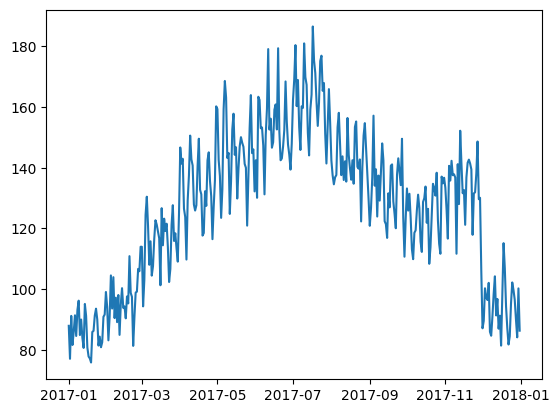

In [57]:
plt.plot(smodel.fit_predict(y_diff, n_periods=365)*seasonal_test.seasonal*trend_test.trend)
auto_conf = smodel.conf_int(alpha=0.05)

In [58]:
y_forec, conf_int  = smodel.predict(365,return_conf_int=True,alpha=0.05)

In [64]:
conf_int

array([[0.75228812, 1.24141847],
       [0.73535316, 1.22448351],
       [0.70961922, 1.19874956],
       [0.71942114, 1.20855148],
       [0.7820968 , 1.27122715],
       [0.77534393, 1.26447428],
       [0.75829523, 1.24742557],
       [0.72512445, 1.2142548 ],
       [0.71360963, 1.20273997],
       [0.7091958 , 1.19832615],
       [0.79389941, 1.28302976],
       [0.78284413, 1.27197447],
       [0.76759958, 1.25789482],
       [0.80555737, 1.29585261],
       [0.74305817, 1.23335342],
       [0.72723653, 1.21753177],
       [0.76877803, 1.25907328],
       [0.72143294, 1.21172819],
       [0.8091818 , 1.29947704],
       [0.78270314, 1.27299839],
       [0.73548126, 1.22577651],
       [0.72924002, 1.21953527],
       [0.78569509, 1.27599034],
       [0.72220852, 1.21250376],
       [0.75038444, 1.25671885],
       [0.75807666, 1.26441106],
       [0.74765507, 1.25398948],
       [0.74430566, 1.25064007],
       [0.74957365, 1.25590806],
       [0.74136236, 1.24769677],
       [0.

In [62]:
pd.DataFrame(y_forec, columns=['forecast'])

,forecast
2017-01-01,0.996853
2017-01-02,0.979918
2017-01-03,0.954184
2017-01-04,0.963986
2017-01-05,1.026662
...,...
2017-12-27,1.001545
2017-12-28,1.001545
2017-12-29,1.001545
2017-12-30,1.001545


In [607]:
pd.DataFrame(conf_int, index=df_test.index, columns=['low','high'])

,low,high
date,,
2017-01-01,0.746738,1.261708
2017-01-02,0.730612,1.245582
2017-01-03,0.690658,1.205629
2017-01-04,0.700385,1.215356
2017-01-05,0.777865,1.292835
...,...,...
2017-12-27,0.733549,1.268760
2017-12-28,0.733549,1.268760
2017-12-29,0.733549,1.268760


In [559]:
auto_conf = auto_conf.rename(columns={0:"low",1:'high'})
auto_conf

,low,high
intercept,0.993083,1.007967
sigma2,0.016914,0.019819


In [ ]:
plt.figure(figsize=(15,5))


plt.plot((conf_int['low']*seasonal_test.seasonal*trend_test.trend), label='low', c='grey', ls='--')
plt.plot((conf_int['high']*seasonal_test.seasonal*trend_test.trend), label='high', c='grey', ls='--')
plt.plot(df_train, c='blue')
plt.plot(df_test, c='green')
plt.plot(forecast, c='orange')
plt.legend()
plt.fill_between(df_test.index, (conf_int['low']*seasonal_test.seasonal*trend_test.trend), (conf_int['high']*seasonal_test.seasonal*trend_test.trend), color='k', alpha=.15);

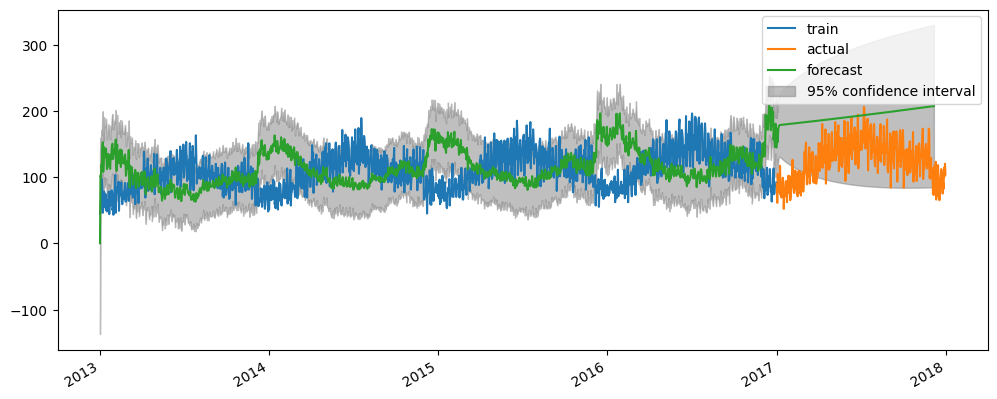

In [119]:
from statsmodels.graphics.tsaplots import plot_predict

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(df_train['sales'], label='train')
plt.plot(df_test['sales'], label='actual')
plot_predict(arima, start=0, end=1800, ax=axs);

In [261]:
df_train

,sales
date,
2013-01-01,45
2013-01-02,53
2013-01-03,65
2013-01-04,66
2013-01-05,97
...,...
2016-12-27,76
2016-12-28,88
2016-12-29,88


In [613]:
result_mul.seasonal[-365:]

date
2017-01-01    0.717666
2017-01-02    0.640494
2017-01-03    0.777679
2017-01-04    0.688655
2017-01-05    0.681271
                ...   
2017-12-27    0.741014
2017-12-28    0.690552
2017-12-29    0.645473
2017-12-30    0.769084
2017-12-31    0.662138
Freq: D, Name: seasonal, Length: 365, dtype: float64

In [88]:
PD.result_mul.trend.dropna().index[-1]+pd.Timedelta(days=1)

Timestamp('2017-07-02 00:00:00', freq='D')